# Train FASHION-MNIST dataset using neural network with fully connected layers

In [36]:
%matplotlib inline

import numpy as np
import torch

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
dataset_root = "./data/fashion_pt" 
Dataset = FashionMNIST

## Data

In [37]:
transform = transforms.ToTensor()
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = Dataset(dataset_root, download=True, train=True, transform=transform)
testset = Dataset(dataset_root, download=True, train=False, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

### Data loader

In [38]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

tensor(0) tensor(9) 16


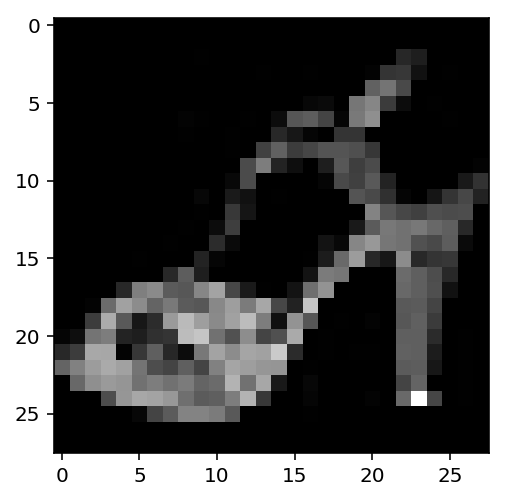

In [39]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = np.random.choice(batch_size)
print(labels.min(), labels.max(), len(labels))
plt.imshow(np.squeeze(images[idx]), cmap='gray')

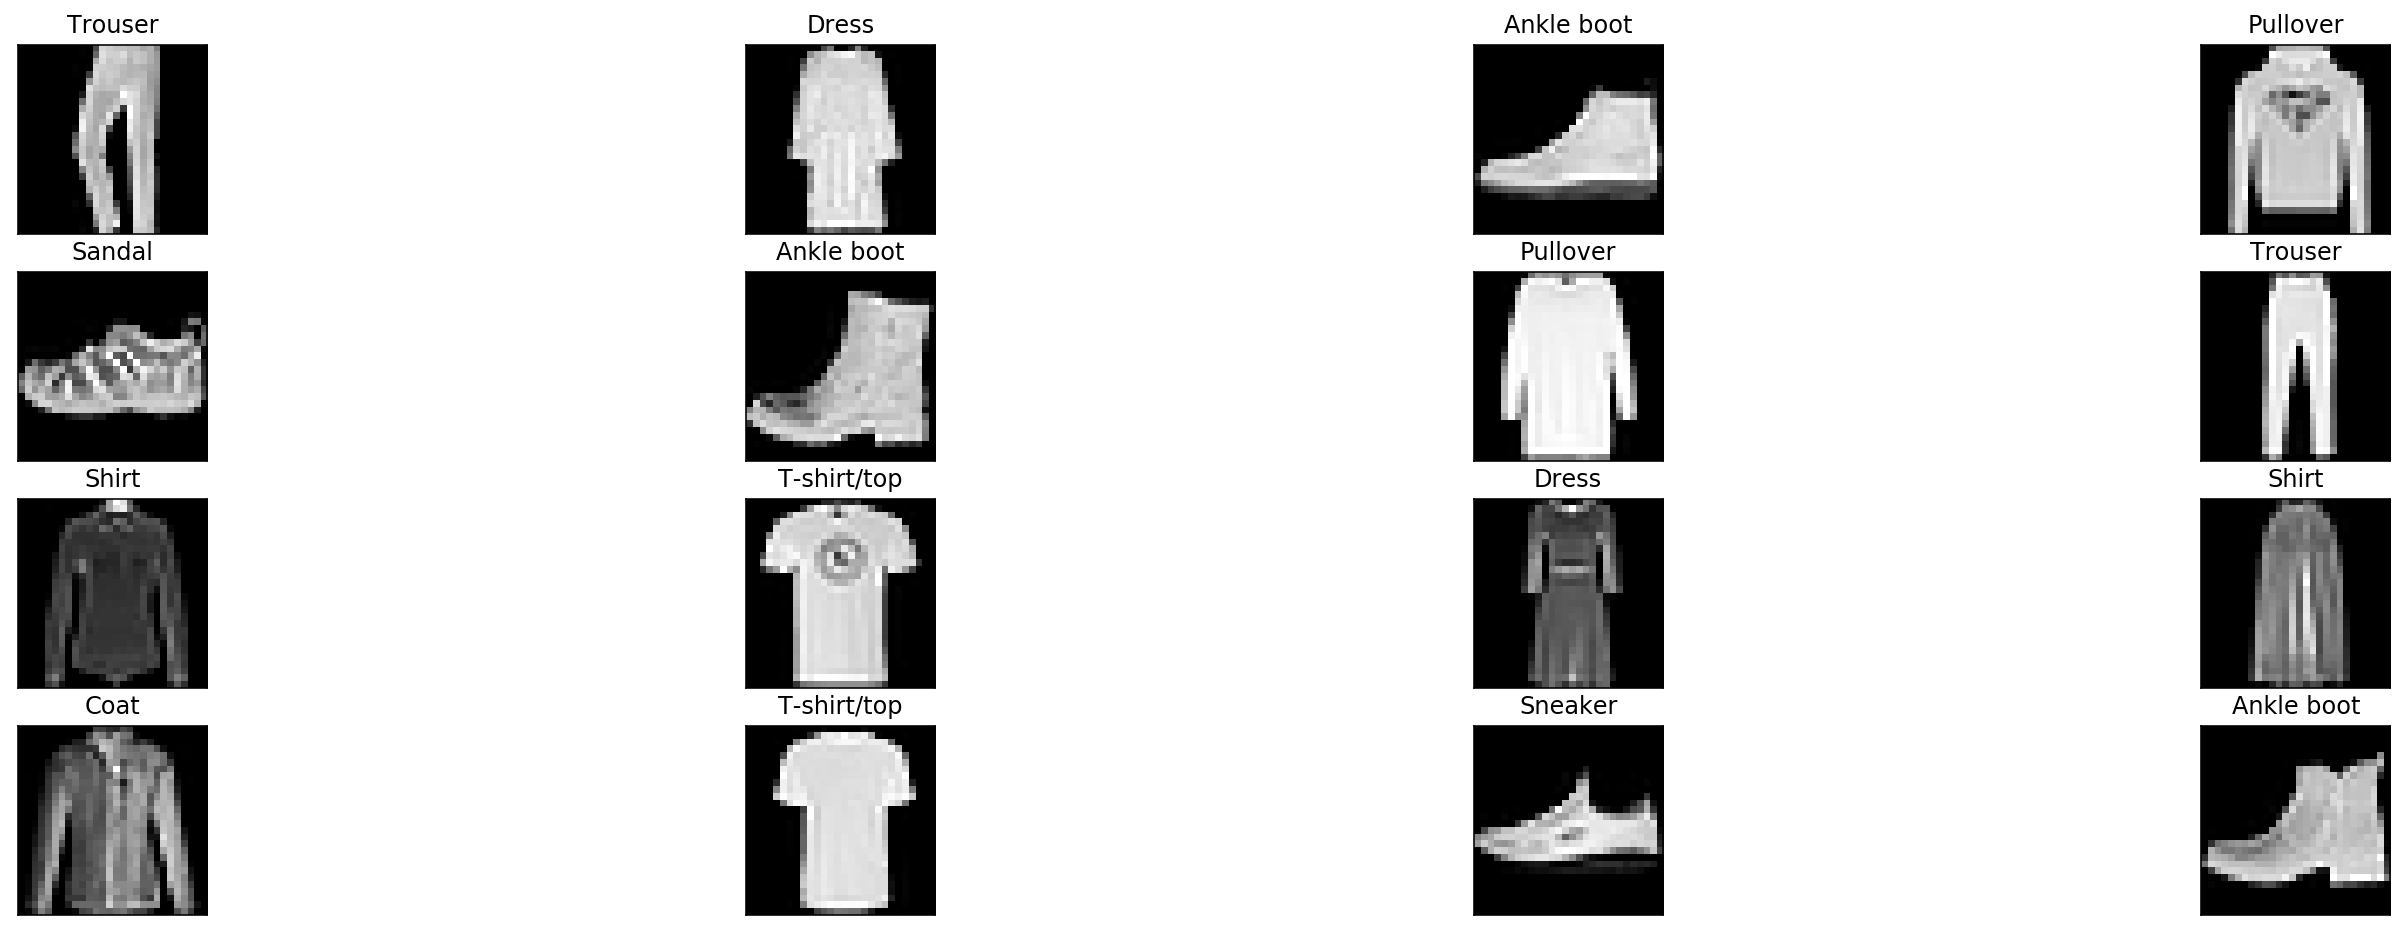

In [15]:
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

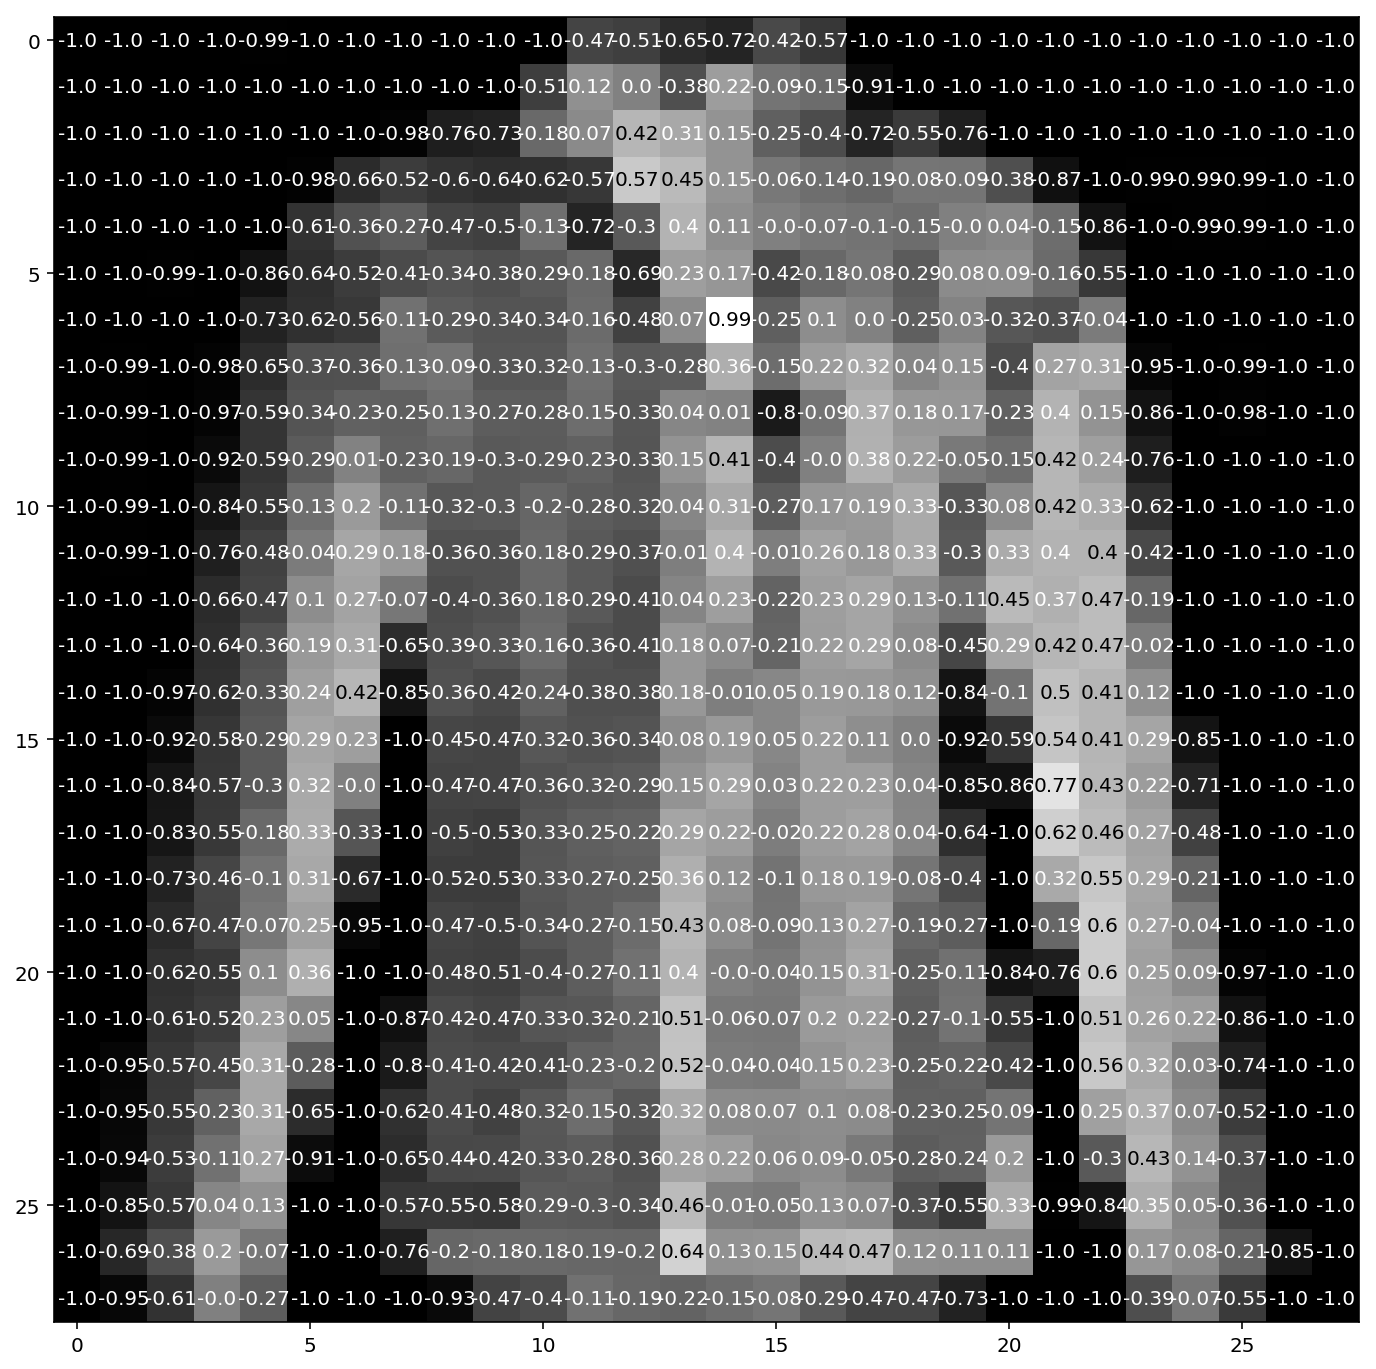

In [16]:
idx = np.random.choice(batch_size)
img = np.squeeze(images[idx])
# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Let's define Neural Network with pytorch

In [17]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [49]:
input_dim = 28 * 28

class LinearNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
        
model = LinearNN()
model

LinearNN(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [50]:
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

### Let's see how it performs before training

In [52]:
correct = 0
total = 0

for images, labels in test_loader:

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100.0 * correct.item() / total

print(accuracy,"%")

9.74 %


## Let's train it

In [53]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [55]:
n_epochs = 20 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 0.5717107260376215
Epoch: 1, Batch: 2000, Avg. Loss: 0.5513098600506783
Epoch: 1, Batch: 3000, Avg. Loss: 0.5682851767521352
Epoch: 2, Batch: 1000, Avg. Loss: 0.5599478602744639
Epoch: 2, Batch: 2000, Avg. Loss: 0.5513284281753004
Epoch: 2, Batch: 3000, Avg. Loss: 0.5496891619749367
Epoch: 3, Batch: 1000, Avg. Loss: 0.5384693787358701
Epoch: 3, Batch: 2000, Avg. Loss: 0.5426997814681381
Epoch: 3, Batch: 3000, Avg. Loss: 0.5683939870670438
Epoch: 4, Batch: 1000, Avg. Loss: 0.543502092719078


KeyboardInterrupt: 

In [56]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
model.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.613012

Test Accuracy of T-shirt/top: 86% (868/1000)
Test Accuracy of Trouser: 93% (937/1000)
Test Accuracy of Pullover: 68% (684/1000)
Test Accuracy of Dress: 86% (860/1000)
Test Accuracy of  Coat: 84% (846/1000)
Test Accuracy of Sandal: 91% (917/1000)
Test Accuracy of Shirt: 29% (298/1000)
Test Accuracy of Sneaker: 94% (948/1000)
Test Accuracy of   Bag: 90% (901/1000)
Test Accuracy of Ankle boot: 89% (894/1000)

Test Accuracy (Overall): 81% (8153/10000)


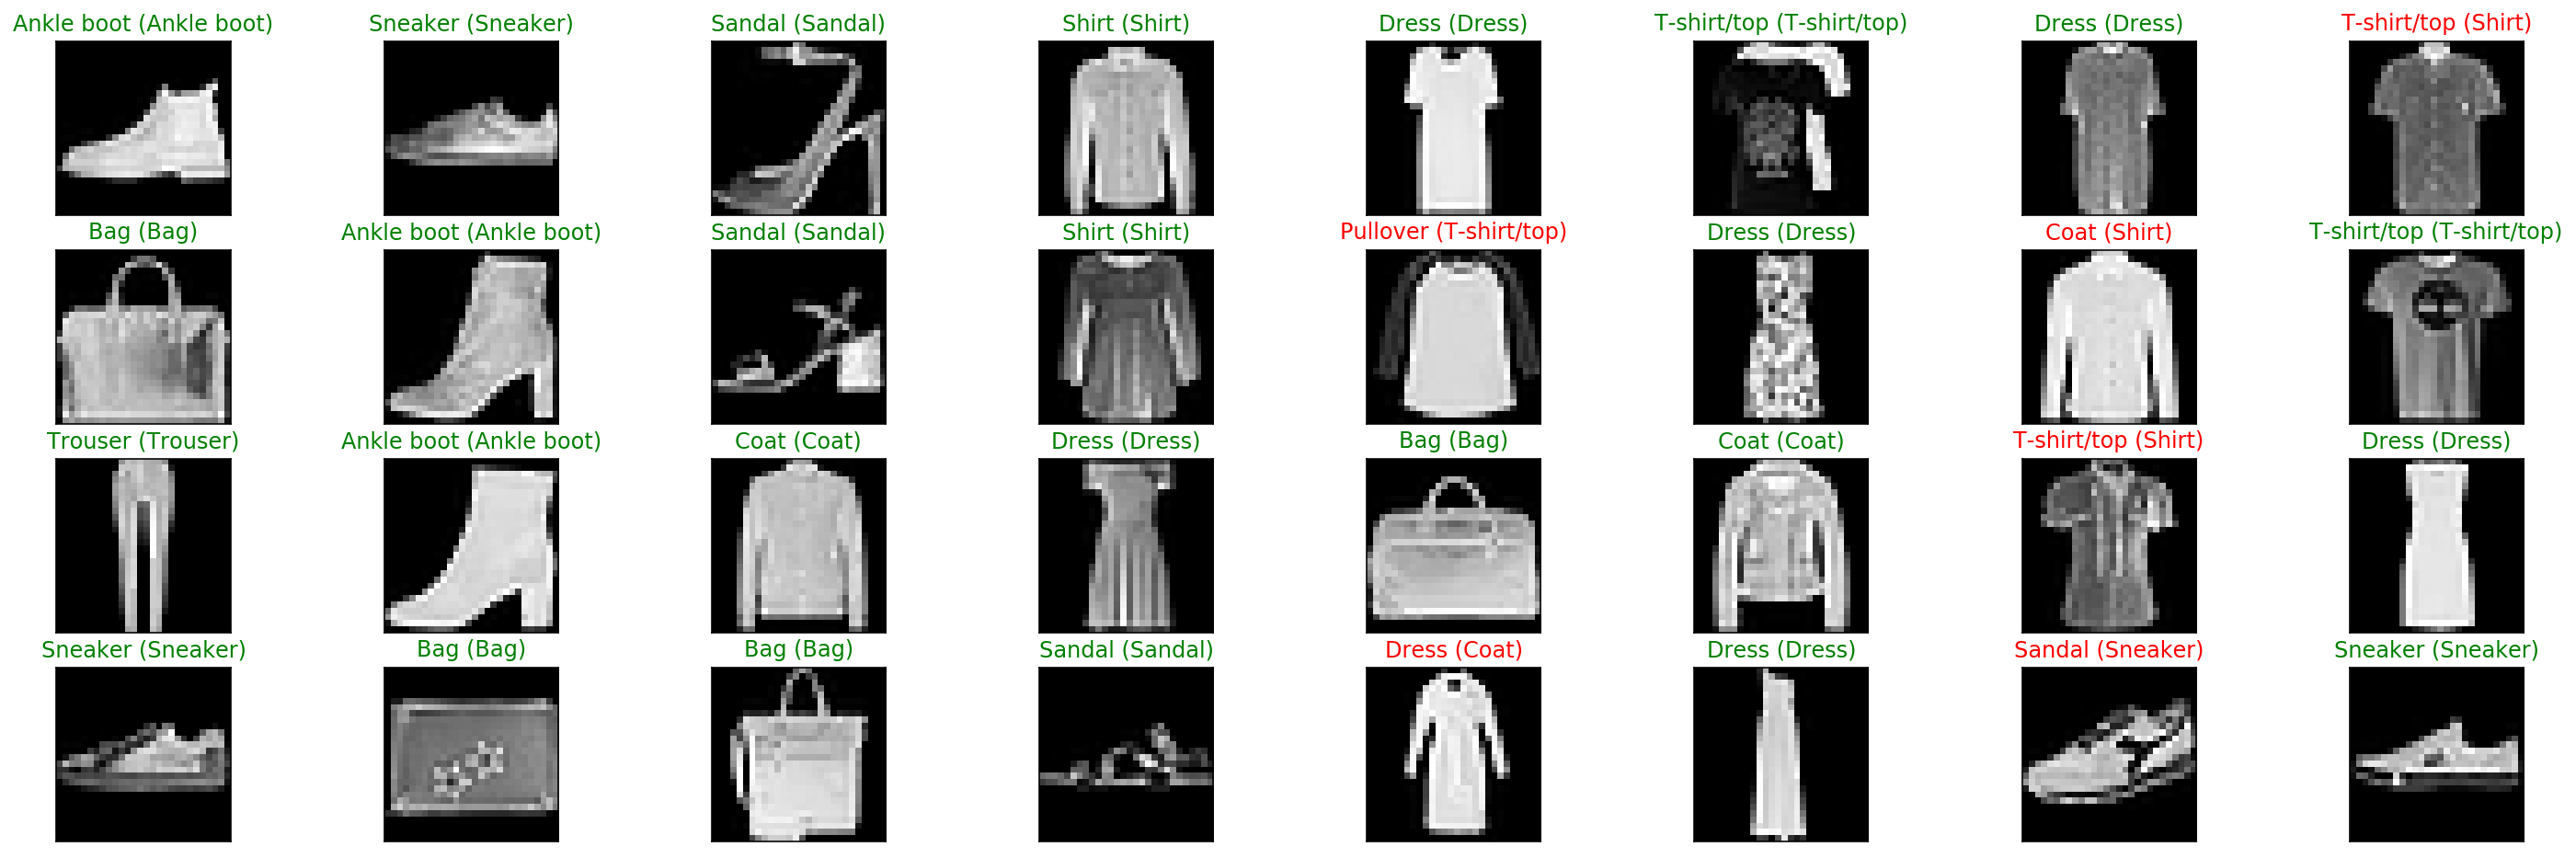

In [58]:
batch_size=32
test_loader2 = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# obtain one batch of test images
dataiter = iter(test_loader2)
images, labels = dataiter.next()
# get predictions
outputs = model(images)
preds = np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [59]:
from sklearn.metrics import confusion_matrix

batch_size=10000
test_loader3 = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)
dataiter = iter(test_loader3)
images, labels = dataiter.next()
outputs = model(images)
array  = confusion_matrix(labels, np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy()))

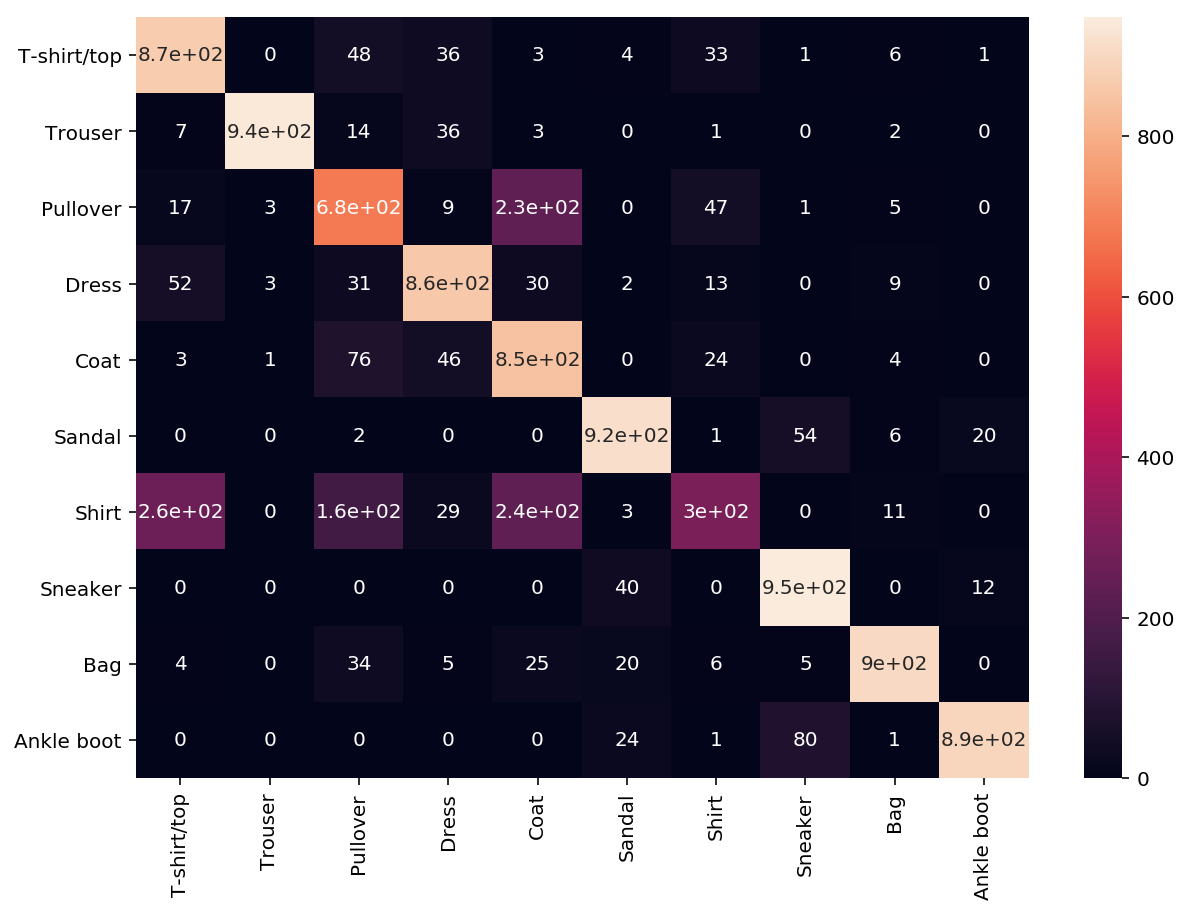

In [60]:
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes ])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)